# Technical Test Pythae

To run this notebook you will need a Python version >=3.8

## Preliminaries: Setup environnement & Data

In [ ]:
#%pip install torchvision torch matplotlib

In [4]:
import torch
import torchvision
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 113279452.14it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 51372219.60it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28462098.21it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9769501.93it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [12]:
example_data.shape

torch.Size([1000, 1, 28, 28])

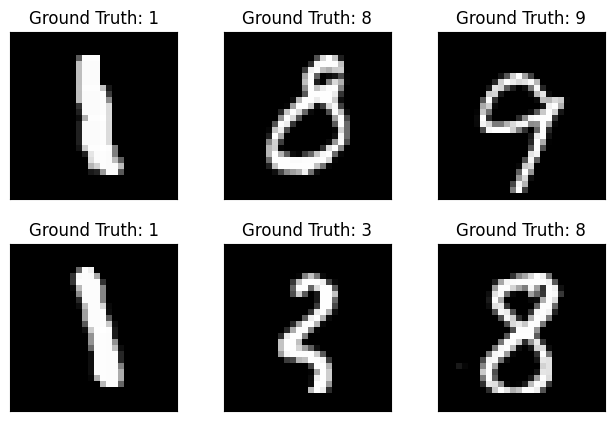

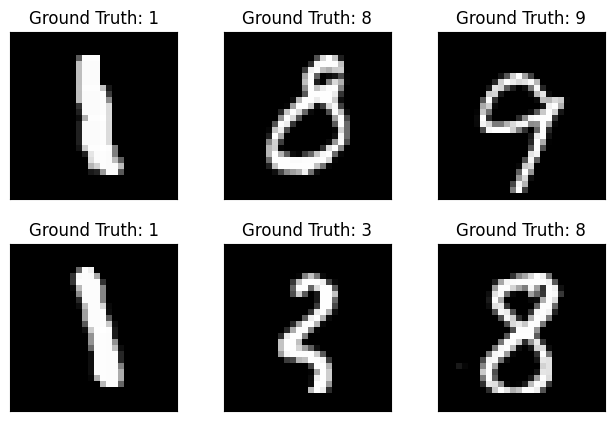

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [14]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [29]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [30]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [34]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/kaggle/working/model.pth')
      torch.save(optimizer.state_dict(), '/kaggle/working/optimizer.pth')

In [35]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [36]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_34/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3101, Accuracy: 1095/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291264
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.349574
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.270817
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.288686
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.272091
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.295456
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.244493
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.243916
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.218489
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.196870
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.174653
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.124590
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.077691
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.010999
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.940464
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.818517
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.717691
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.882664
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.674577
Train Epoch: 1 [12160

ValueError: x and y must be the same size

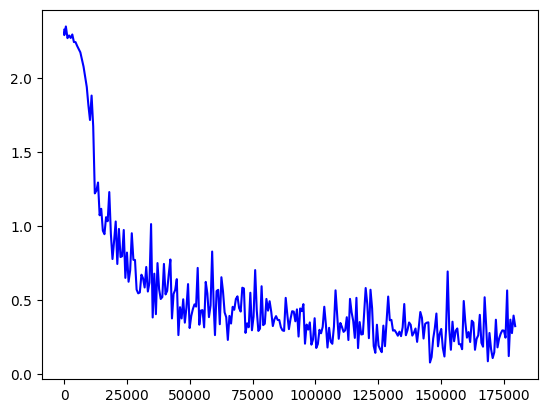

In [37]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [38]:
with torch.no_grad():
  output = network(example_data)

/tmp/ipykernel_34/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


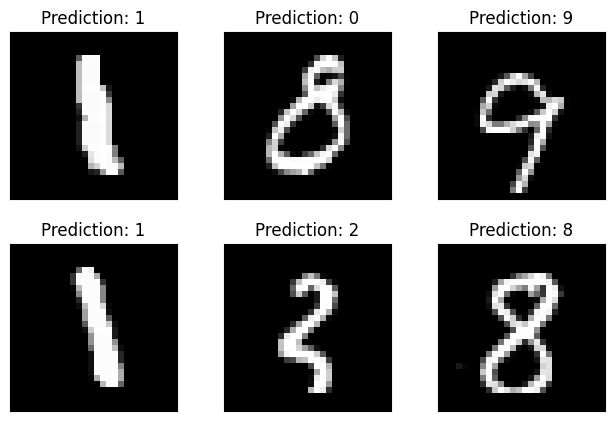

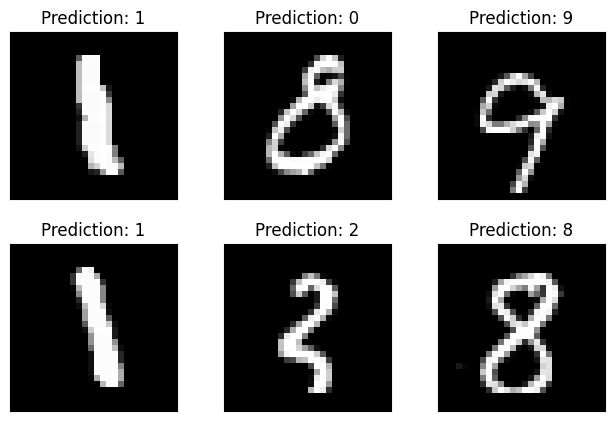

In [39]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [40]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [42]:
network_state_dict = torch.load('/kaggle/working/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/kaggle/working/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)


In [43]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/tmp/ipykernel_34/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.186856
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.245908
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.468844
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.194571
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.183438
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.266015
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.249422
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.253411
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.250473
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.217252
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.371851
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.170381
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.304375
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.354415
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.188026
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.181530
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.376350
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.111847
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.482707
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.142026
Train Epoch: 4 [12800/60000 (

In [45]:
with torch.no_grad():
  output_continued = continued_network(example_data)

/tmp/ipykernel_34/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


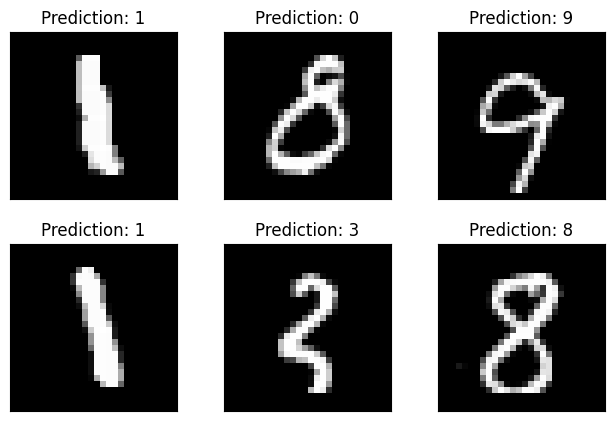

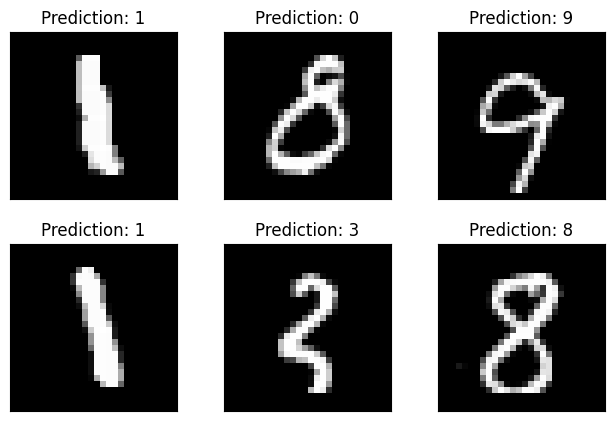

In [46]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output_continued.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

as we can see our model has problems to classify 8 and 0, it might be interesting to add more training datas on those numbers